In [1]:
import time
import numpy as np
import pandas as pd
import cvxpy as cp
import clarabel
import scs
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from notebook_utils.utils import * 
from pycss.utils import *
from pycss.CSS import * 
from pycss.subset_selection import complement 
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as n2r
from rpy2.robjects.vectors import StrVector

In [2]:
def avg_R2(Sigma, S, standardized=True, include=True):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    if not include:
        S_comp = complement(p, S)
    else:
        S_comp = np.arange(p)
    resid_var = np.diag(Sigma_R)[S_comp]
    if standardized:
        return 1 - np.mean(np.diag(Sigma_R)[S_comp])
    else:
        var = np.diag(Sigma)[S_comp]
        return np.mean((var - resid_var)/var)

In [5]:
standardize = True

T = pd.read_csv("../data/topic_exposure.csv").to_numpy()[:, 1:].astype(float)
D = pd.read_csv("../data/specific_variance.csv").to_numpy()[:, 1:].astype(float)
X = pd.read_csv("../data/factor_exposure.csv").to_numpy()[:, 1:].astype(float)
F = pd.read_csv("../data/factor_covariance.csv").to_numpy()[:, 1:].astype(float)

V = X @ F @ X.T + np.diag(np.squeeze(D))
Sigma = T.T @ V @ T

p = Sigma.shape[0]

cut = 50
cut_indices = np.random.choice(np.arange(p), size=cut, replace=False)
Sigma = Sigma[:cut, :cut]

p = Sigma.shape[0]

if standardize:
    Sigma = standardize_cov(Sigma)

eigs, vecs = np.linalg.eig(Sigma)
wh = eigs > 0
eigs = np.real(eigs[wh])
vecs = np.real(vecs[:, wh])
X = np.real(np.sqrt(p) * np.sqrt(eigs)[:, None] * vecs.T)
print(np.allclose(1/p * X.T @ X, Sigma))

True


In [6]:
n2r.activate()
glmnet = rpackages.importr('glmnet')
base = rpackages.importr('base')

In [7]:
p_max = 30
num_inits = 25

### CPFS

In [8]:
def cpfs(X, lamb, tol = 1e-6):
    p = X.shape[1]
    Sigma = X.T @ X
    
    I_ = np.eye(p + 1)
    I_[p, p] = 0
    P = scipy.sparse.kron(scipy.sparse.csc_array(I_), np.triu(Sigma), format='csc')
    
    q = -1 * Sigma.flatten()
    q = np.hstack([q, lamb*np.ones(p)])
    
    A_right_side = scipy.sparse.kron( -1*np.ones(2*p), np.eye(p)).T
    A = scipy.sparse.vstack([-1 *scipy.sparse.eye(p**2),  scipy.sparse.eye(p**2)])
    A = scipy.sparse.hstack([A, A_right_side]).tocsc()
    
    b = np.zeros(2 * (p**2))

    cones = [clarabel.NonnegativeConeT(2 * (p**2))]
    settings = clarabel.DefaultSettings()
    settings.verbose=False

    solver = clarabel.DefaultSolver(P,q,A,b,cones,settings)
    solution = solver.solve()

    #coeff = np.array(solution.x[: (p**2)]).reshape((p, p)).T
    s = np.array(solution.x[(p**2): ])
    print(s)
    return np.where(s > tol)[0]


In [9]:
def cpfs_cvxpy(X, reg_coeff, tol = 1e-6):
    A = cp.Variable((p, p))
    s = cp.Variable(p)
    lamb = cp.Parameter(nonneg=True)
    objective = cp.Minimize(cp.sum(cp.sum_squares(X  - X @ A)) + lamb * cp.sum(s))
    constraints = [-s[:, None] <= A, A <= s[:, None], s >= 0]
    prob = cp.Problem(objective, constraints)


    lamb.value = reg_coeff
    result = prob.solve(solver='CLARABEL')
    return np.where(s.value > 1e-6)[0]

In [38]:
num_selected = []
css_cpfs_var_explained = []

lambs = np.flip(np.logspace(0, 3.5, 100))
cpfs_Ss = []
for lamb in tqdm(lambs):
    S = cpfs_cvxpy(X, lamb)
    
    #if len(S) > 0:
        #print(S)
        #print(lamb)
        #break
    df = len(S)
    if df > 0 and df <= p_max and df not in num_selected:
        cpfs_Ss.append(S)
        num_selected.append(df)
        css_cpfs_var_explained.append(avg_R2(Sigma, S))

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
cpfs_df = pd.DataFrame({'Number of Principal Components/Variables': num_selected , 'Average R^2': css_cpfs_var_explained})

In [39]:
cpfs_max_eig = []
cpfs_min_eig = []
cpfs_eig_var = []
cpfs_dfs = []
cpfs_det = []
cpfs_det_sign = []
for S in cpfs_Ss:
    cpfs_dfs.append(len(S))
    Sig = Sigma[S, :][: , S]
    eig = np.linalg.eig(Sig)[0]
    cpfs_max_eig.append(np.max(eig))
    cpfs_min_eig.append(np.min(eig))
    cpfs_eig_var.append(np.std(eig))
    cpfs_det.append(np.linalg.slogdet(Sig)[1])
    cpfs_det_sign.append(np.linalg.slogdet(Sig)[0])

### Random

In [27]:
css_random_var_explained = np.zeros((p_max, num_inits))

for i in range(1, p_max + 1):
    for j in range(num_inits):
        S = np.random.choice(np.arange(p), size=i)
        css_random_var_explained[i-1, j] = avg_R2(Sigma, S)


In [9]:
random_df = pd.DataFrame({'Number of Principal Components/Variables': np.array([ num_inits*[i] for i in range(1, p_max+1) ]).flatten() , 'Average R^2': css_random_var_explained.flatten()  } ) 

In [13]:
random_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average R^2': np.max(css_random_var_explained, axis=1)  } ) 

In [56]:
random_max_eig = []
random_min_eig = []
random_eig_var = []
random_det = []
random_det_sign = []
for i in range(1, p_max + 1):
    S = np.random.choice(np.arange(p), replace=False, size=i)
    Sig = Sigma[S, :][: , S]
    eig = np.linalg.eig(Sig)[0]
    random_max_eig.append(np.max(eig))
    random_min_eig.append(np.min(eig))
    random_eig_var.append(np.std(eig))
    random_det.append(np.linalg.slogdet(Sig)[1])
    random_det_sign.append(np.linalg.slogdet(Sig)[0])

### Group Lasso

In [29]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    fit = glmnet.glmnet(X, X, standardize=False, intercept=False, family="mgaussian", alpha=1, dfmax=30)
    
len_dfs = len(fit['df'])
coeff_path = np.dstack([base.as_matrix(fit['beta'][resp]) for resp in fit['beta'].keys()]).transpose((0, 2, 1))
group_lasso_Ss = []
for i in range(len_dfs):
    group_lasso_Ss.append(np.squeeze(np.argwhere(~np.all(coeff_path[:, :, i] == 0, axis=1))))

dfs = fit['df'][1:]
group_lasso_Ss = group_lasso_Ss[1:]
for i in range(len(group_lasso_Ss)):
    if len(group_lasso_Ss[i].shape) == 0:
        group_lasso_Ss[i] = np.array([group_lasso_Ss[i]])

num_selected = []
css_group_lasso_var_explained = []
for i in range(len(fit['df'])):
    df = fit['df'][i]
    if df > 0 and df <= p_max and df not in num_selected:
        num_selected.append(df)
        css_group_lasso_var_explained.append(avg_R2(Sigma, group_lasso_Ss[i]))
            

In [15]:
group_lasso_df = pd.DataFrame({'Number of Principal Components/Variables': num_selected , 'Average R^2': css_group_lasso_var_explained})

In [30]:
lasso_max_eig = []
lasso_min_eig = []
lasso_eig_var = []
lasso_dfs = []
lasso_det = []
lasso_det_sign = []
for S in group_lasso_Ss:
    lasso_dfs.append(len(S))
    Sig = Sigma[S, :][: , S]
    eig = np.linalg.eig(Sig)[0]
    lasso_max_eig.append(np.max(eig))
    lasso_min_eig.append(np.min(eig))
    lasso_eig_var.append(np.std(eig))
    lasso_det.append(np.linalg.slogdet(Sig)[1])
    lasso_det_sign.append(np.linalg.slogdet(Sig)[0])

### Greedy

In [31]:
css_greedy_var_explained = np.zeros(p_max)
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
for i in range(1, p_max + 1):
    css_greedy_var_explained[i - 1] =  avg_R2(Sigma, css.S[:i]) 


In [17]:
greedy_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average R^2': css_greedy_var_explained })

In [32]:
greedy_max_eig = []
greedy_min_eig = []
greedy_eig_var = []
greedy_det = []
greedy_det_sign = []
for i in range(1, p_max + 1):
    Sig = Sigma[css.S[:i], :][: , css.S[:i]]
    eig = np.linalg.eig(Sig)[0]
    greedy_max_eig.append(np.max(eig))
    greedy_min_eig.append(np.min(eig))
    greedy_eig_var.append(np.std(eig))
    greedy_det.append(np.linalg.slogdet(Sig)[1])
    greedy_det_sign.append(np.linalg.slogdet(Sig)[0])

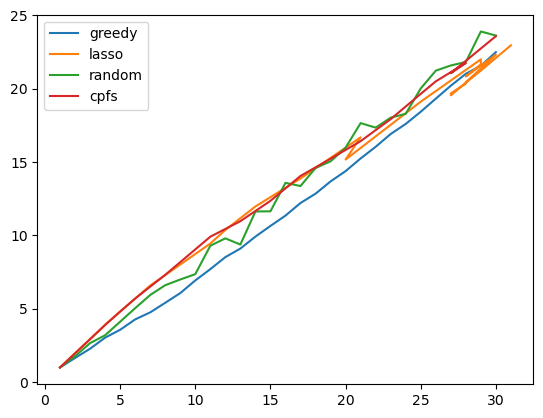

In [57]:
plt.plot(np.arange(1, p_max + 1), greedy_max_eig, label='greedy')
plt.plot(lasso_dfs, lasso_max_eig, label='lasso')
plt.plot(np.arange(1, p_max + 1), random_max_eig, label='random')
plt.plot(cpfs_dfs, cpfs_max_eig, label='cpfs')
plt.legend()

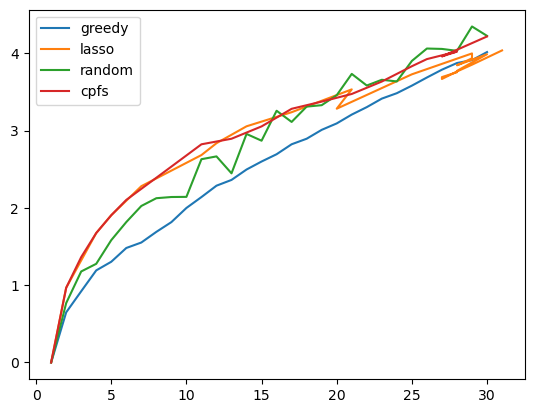

In [58]:
plt.plot(np.arange(1, p_max + 1), greedy_eig_var, label='greedy')
plt.plot(lasso_dfs, lasso_eig_var, label='lasso')
plt.plot(np.arange(1, p_max + 1), random_eig_var, label='random')
plt.plot(cpfs_dfs, cpfs_eig_var, label='cpfs')
plt.legend()

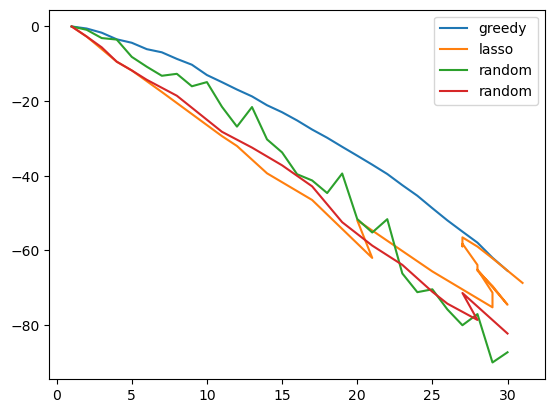

In [59]:
plt.plot(np.arange(1, p_max + 1), greedy_det, label='greedy')
plt.plot(lasso_dfs, lasso_det, label='lasso')
plt.plot(np.arange(1, p_max + 1), random_det, label='random')
plt.plot(cpfs_dfs, cpfs_det, label='random')
plt.legend()

### Swapping

In [18]:
css_swap_var_explained = np.zeros((p_max, num_inits))
for i in tqdm(range(1, p_max + 1)):
    for j in range(num_inits):
        invertible = False
        while not invertible:
            try:
                css.select_subset_from_cov(Sigma, k=i, method='swap')
                invertible=True 
            except: 
                pass 
        css_swap_var_explained[i-1, j] = avg_R2(Sigma, css.S)

  0%|          | 0/30 [00:00<?, ?it/s]

In [180]:
swap_df = pd.DataFrame({'Number of Principal Components/Variables': np.array([ num_inits*[i] for i in range(1, p_max+1) ]).flatten() , 'Average R^2': css_swap_var_explained.flatten()  } ) 

In [19]:
swap_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1) , 'Average R^2': np.max(css_swap_var_explained, axis=1)  } ) 

### PCA

In [20]:
pca_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average R^2': [np.sum(eigs[:i])/np.sum(eigs) for i in range(1, p_max + 1)] })

### Plot

<Axes: xlabel='Number of Principal Components/Variables', ylabel='Average R^2'>

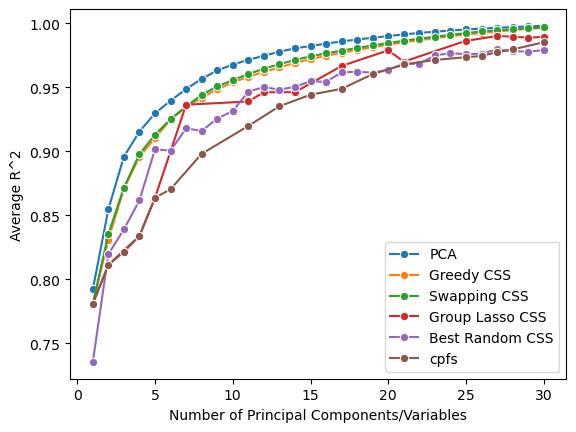

In [23]:
sns.lineplot(data=pca_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('se', 1),
                 label='PCA')

sns.lineplot(data=greedy_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('se', 1),
                 label='Greedy CSS')

sns.lineplot(data=swap_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='Swapping CSS')

sns.lineplot(data=group_lasso_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('se', 1),
                 label='Group Lasso CSS')

sns.lineplot(data=random_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='Best Random CSS')

sns.lineplot(data=cpfs_df,
                 x='Number of Principal Components/Variables', 
                 y='Average R^2', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='cpfs')

#plt.savefig("../figures/blackrock_results.pdf")

/Users/anavsood/mambaforge/envs/css/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


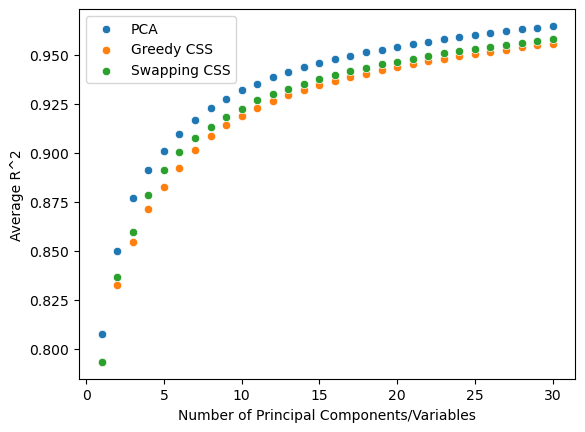

In [53]:
sns.scatterplot(x=np.arange(1, p_max + 1), y=[np.sum(eigs[:i])/np.sum(eigs) for i in range(1, p_max + 1)], label='PCA').set(xlabel="Number of Principal Components/Variables", ylabel="Average R^2" )
sns.scatterplot(x=np.arange(1, p_max + 1), y=css_greedy_var_explained, label='Greedy CSS')
sns.scatterplot(x=np.arange(1, p_max + 1), y=css_swap_var_explained, label='Swapping CSS')

plt.savefig("../figures/blackrock_results.pdf")

In [44]:
print(css_greedy_var_explained)
print(css_swap_var_explained)

[0.7934445  0.83252599 0.8546137  0.87148977 0.88269912 0.89250351
 0.90136511 0.90877926 0.91415754 0.9188751  0.92293612 0.92644305
 0.92968578 0.93218311 0.93458444 0.93680345 0.93877498 0.94052971
 0.94225815 0.94391974 0.94552264 0.94685809 0.94814606 0.94938765
 0.9505486  0.95165954 0.95276112 0.95380683 0.95482028 0.95580765]
[0.7934445  0.83667549 0.85977817 0.87841295 0.89154404 0.90048168
 0.90750973 0.9132941  0.91831734 0.92265138 0.92686026 0.93029303
 0.93286086 0.93538281 0.93780586 0.93975566 0.94162754 0.94343019
 0.94513622 0.94661481 0.94808736 0.94950522 0.95086619 0.95201086
 0.95313978 0.95420381 0.95524576 0.95630403 0.95725886 0.9581948 ]


Compare greedy runtime to naive

In [3]:
tol=1e-10
p_max = 30

css = CSS()
start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
end = time.time()
efficient_time = end - start

start = time.time()
S = []
for i in tqdm(range(p_max)):
    options = complement(p, S)
    best_val = np.inf
    best_j = np.nan
    for j in options:
        option_val = np.mean(np.diag(regress_off(Sigma, S + [j])))
        if option_val < best_val:
            best_val = option_val
            best_j = j
    S.append(best_j)
end = time.time()
naive_time = end - start

print(naive_time/efficient_time)

  0%|          | 0/30 [00:00<?, ?it/s]

3849.2163889899357


Compare swapping runtime to naive

In [5]:
p_max = 30

N = 100

start = time.time()
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='swap')
end = time.time()
# time to select entire subset
whole_time = end - start 

start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='swap', S_init=css.S)
end = time.time()
# time to efficiently verify a local optimum is a local optimum
efficient_time = end - start

start = time.time()
S = css.S.copy()
for i in range(len(S)):
    current_val = np.mean(np.diag(regress_off(Sigma, S)))
    options = np.delete(np.arange(p), S)
    best = np.inf 
    best_S_option = np.nan
    for j in options:
        S_option = S.copy()
        S_option[i] = j
        option_val = np.mean(np.diag(regress_off(Sigma, S_option)))
        if option_val < best:
            best = option_val
            best_S_option = S_option
    if best < current_val:
        S = best_S_option.copy()
    break
end = time.time()
# time to naively verify a local optimum is a local optimum
naive_time = (end - start) * p_max

In [6]:
print(whole_time)
print(naive_time/efficient_time)

0.4303879737854004
5527.618619755847


In [31]:
# redefine swapping selection so that it returns the number of iterations it takes  
def swapping_subset_selection(Sigma, 
                              k,
                              objective,
                              max_iter=100,
                              S_init=None,
                              tol=TOL,
                              flag_colinearity=False):

    """
    Given a covariance `Sigma`, a subset size `k`, and an objective function `objective`
    returns the subset of variables `k` which minimize the objective selected by a gradient descent
    like iterative swapping algorithm. 

    Parameters
	----------
	Sigma : np.array
	    A `(p, p)`-shaped covariance matrix. 
    k : int
        Size of subset to search for.
    objective : Callable[np.array, bool, np.float]
        A python function which defines the objective. On each iteration the variable which 
        minimizes objective will be selected.
    max_iter : int, default=`100`
        Maximum number of iterations to run the swapping algorithm. If algorithm has not 
        converged within `max_iter` iterations, the algorithm will terminate and provide 
        results in its current state. In this case `converged` will be `False.
    S_init : np.array, default=`None`
        Intial subset to start the algorithm with. If not included, an initial subset is 
        selected uniformly randomly.  
    tol : float, default=`TOL`
        Tolerance at which point we consider a variable to have zero variance.
    flag_colinearity : bool, default=`True`
        Whether or not to flag colinearity issues and terminate upon their happening. 
	
    Returns 
	-------
	S : np.array
        The selected subset, in order it was selected.
    Sigma_R : np.array
        The `(p, p)`-shaped residual covariance matrix resulting from regressing the selected subset
        out of all the varibles (including themselves). 
    S_init : np.array
        The inital subset that the algorithm starts with.
    converged : bool
        Whether the algorithm has converged. If `converged` is `False` and the `errors` list is non-empty 
        then `S` and `Sigma_R` must be `None`. 
    errors : List[ValueError]
         List of ValueError objects detailing what the colinearity issues are. 
	"""

    converged = False
    p = Sigma.shape[0]
    d = p-k
    idx_order = np.arange(p)
    
    if S_init is None:
        S_init = np.random.choice(idx_order, k, replace=False)
    elif len(S_init) != k:
        raise ValueError("Initial subset must be of length k.")
    
    Sigma_R = Sigma.copy()
    # these will always be the indices of the selected subset
    subset_idxs = np.arange(d, p)
    # swap initial variables to bottom of Sigma 
    swap_in_place(Sigma_R, subset_idxs, S_init, idx_order=idx_order)
    S = idx_order[d:].copy()
    Sigma_S = Sigma[:, S][S, :].copy()
    invertible, Sigma_S_L = is_invertible(Sigma_S) 
    
    if not invertible:
        return None, None, S_init, converged, populate_colinearity_errors(S)
    
    regress_off_in_place(Sigma_R, np.arange(d, p))
    zero_idxs = np.where(np.diag(Sigma_R)[:d] <= tol)[0]
    num_zero_idxs = len(zero_idxs)
    
    if flag_colinearity and num_zero_idxs > 0:
        return None, None, S_init, converged, populate_colinearity_errors(S, responses=idx_order[zero_idxs])

    # number of completed iterations
    N = 0
    # counter of how many consecutive times a selected variable was not swapped
    not_replaced = 0
    # permutation which shifts the last variable in the subset to the top of the subset
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    break_flag = False 

    while N < max_iter and (not break_flag):
        for i in range(k):
            S_0 = S[0]
            # Remove first variable from selected subset 
            T = S[1:]

            # Update cholesky after removing first variable from subset 
            Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L) 

            # Update residual covariance after removing first variable from subset
            v = Sigma[:, S_0] - Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, Sigma[T, S_0]) if k > 1 else Sigma[:, S_0]
            reordered_v = v[idx_order]
            Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]

            # Swap first variable from subset to to top of residual matrix 
            swap_in_place(Sigma_R, np.array([0]), np.array([d]), idx_order=idx_order)  
        
            # If not flag_colinearity, find indices of variables with zero variance
            if not flag_colinearity:
                zero_idxs = np.where(np.diag(Sigma_R)[:(d + 1)] <= tol)[0]
                num_zero_idxs = len(zero_idxs)
                # In residual matrix, swap variables with zero indices to right above currently selected subset (of size k-1)
                swap_in_place(Sigma_R, zero_idxs, np.arange(d + 1 - num_zero_idxs, d + 1), idx_order=idx_order)
            else:
                num_zero_idxs = 0
        
            # update num_active
            num_active = d + 1 - num_zero_idxs 

            # compute objectives and for active variables and find minimizers
            obj_vals, colinearity_error_idxs = objective(Sigma_R[:num_active, :num_active], flag_colinearity=flag_colinearity, tol=tol)

            if len(colinearity_error_idxs[0]) > 0:
                return None, None, S_init, converged, populate_colinearity_errors(S[:i], 
                                                                                  idx_order[colinearity_error_idxs[0]], 
                                                                                  idx_order[colinearity_error_idxs[1]])
        
            choices = np.flatnonzero(obj_vals == obj_vals.min())

            # if removed variable is a choice, select it, otherwise select a random choice
            if 0 in choices:
                not_replaced += 1
                j_star = 0 
            else:
                not_replaced = 0
                j_star = np.random.choice(choices)

            # Add new choice as the last variable in selected subset
            S_new = idx_order[j_star]
            S[:k-1] = S[1:]
            S[k-1] = S_new
            # Update cholesky after adding new choice as last variable in selected subset 
            Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma[S_new, S])
            # In residual covariance, regress selected variable off the remaining
            #regress_one_off_in_place(Sigma_R[:(d+1), :(d+1)], j_star) #alternative option
            regress_one_off_in_place(Sigma_R[:num_active, :num_active], j_star)
            # In residual covariance swap new choice to top of selected subset and then permute selected subset
            # so the new choice is at the bottom, reflecting S
            swap_in_place(Sigma_R, np.array([j_star]), np.array([d]), idx_order=idx_order)
            perm_in_place(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=idx_order)
        
            if not_replaced == k:
                converged=True
                break_flag=True
                break

        N += 1

    perm_in_place(Sigma_R, np.arange(p), np.argsort(idx_order))
    return N-1, S, Sigma_R, S_init, converged, []

In [33]:
B = 100
iters = []
for i in tqdm(range(B)):
    try:
        N, _, _, _, _, _ = swapping_subset_selection(Sigma, p_max, css_objective)
        iters.append(N)
    except:
        pass

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 3.,  0., 45.,  0.,  0., 31.,  0., 15.,  0.,  2.]),
 array([2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2, 5.6, 6. ]),
 <BarContainer object of 10 artists>)

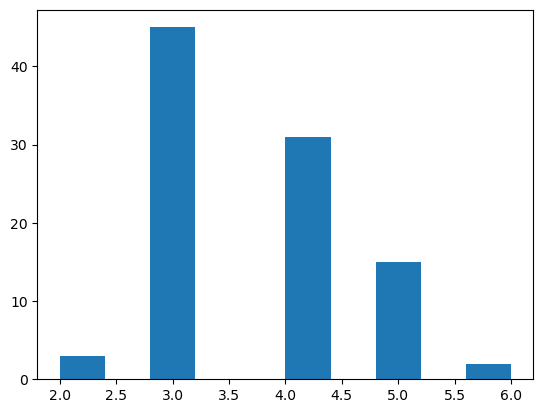

In [34]:
plt.hist(iters)

In [7]:
print(naive_time * np.median(iters))
print(naive_time * np.mean(iters))

2750.4223251342773
2562.893530238758


## Group Lasso Experiments

In [405]:
nonzero = 100
beta = np.hstack([1*np.ones(nonzero), np.zeros(p - nonzero)])
y = X @ beta # + np.random.normal(0, 0.1, len(X))

In [406]:
from sklearn.linear_model import LinearRegression

selected = []
for _ in tqdm(range(nonzero)):
    best = np.nan
    lowest_error = np.inf
    not_selected = complement(p, selected)
    for i in not_selected:
        potential_selected = np.array(selected + [i])
        regr = LinearRegression()
        regr.fit(X[:, potential_selected], y)
        potential_error = np.linalg.norm(regr.predict(X[:, potential_selected]) - y)
        if potential_error < lowest_error:
            lowest_error = potential_error
            best = i
    selected.append(best)

  0%|          | 0/100 [00:00<?, ?it/s]

In [407]:
regr = LinearRegression()
regr.fit(X[:, selected], y)
error = np.linalg.norm(regr.predict(X[:, selected]) - y)
print(error)

4.67626728471705


In [459]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    fit = glmnet.glmnet(X, y, standardize=False, intercept=False, alpha=1, nlambda=10, lambda_min_ratio=0.00001)

In [460]:
fit['df']

array([  0,  10,  27,  57, 107], dtype=int32)

In [502]:
selected = np.where(base.as_matrix(fit['beta'])[:, np.where(fit['df'] == 107)[0][0]] > 0)[0]

In [503]:
regr = LinearRegression()
regr.fit(X[:, selected], y)
error = np.linalg.norm(regr.predict(X[:, selected]) - y)
print(error)

20.119107823015725


In [499]:
selected = np.random.choice(p, 107)
regr = LinearRegression()
regr.fit(X[:, selected], y)
error = np.linalg.norm(regr.predict(X[:, selected]) - y)
print(error)

49.643679021750295


In [243]:
np.where(dfs == 11)[0][0]

array([16])

In [211]:
X_ = X.copy()
X_ /= np.linalg.norm(X_, axis=0)[None, :]
selected = []
for i in range(nonzero):
    not_selected = complement(p, selected)
    t = not_selected[np.argmax(np.square(X_[:, not_selected].T @ y))]
    selected.append(t)
    weights = X_.T @ X_[:, t]
    X_ -=  X_[:, t].reshape((len(X_[:, t]), 1)) @ weights.reshape((1, len(weights)))
    X_ /= np.linalg.norm(X_, axis=0)[None, :]

In [212]:
selected

[22, 9, 141, 738, 5, 3, 7, 2, 1, 0]

In [ ]:
np.linalg.norm(y - )

In [90]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    fit = glmnet.glmnet(X, y, standardize=False, intercept=False, alpha=1, nlambda=100)

In [91]:
coeffs = base.as_matrix(fit['beta'])
for i in range(coeffs.shape[1]):
    if len(set(np.arange(nonzero)).intersection(np.where(coeffs[:, i] > 0)[0])) == nonzero:
        print(len(np.where(coeffs[:, i] > 0)[0]))
        break

In [40]:
rho = 0.9

cov = np.array([[1, rho, 0, 0], [rho, 1, 0, 0] ,[0, 0, 1, rho] ,[0, 0, rho, 1]])

p = cov.shape[0]
n = 50
X = np.random.multivariate_normal(mean=np.zeros(p), cov=cov, size=n)

In [41]:
eigs, vecs = np.linalg.eig(cov)
wh = eigs > 0
eigs = np.real(eigs[wh])
vecs = np.real(vecs[:, wh])
X = 1/np.sqrt(p) * np.real(np.sqrt(p) * np.sqrt(eigs)[:, None] * vecs.T)

In [59]:
weight_path[: , :, 8]

array([[0.00062846, 0.00056559, 0.        , 0.        ],
       [0.0002244 , 0.00024936, 0.        , 0.        ],
       [0.        , 0.        , 0.00062846, 0.00056559],
       [0.        , 0.        , 0.0002244 , 0.00024936]])

In [53]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    fit = glmnet.glmnet(X, X, standardize=False, intercept=False, family="mgaussian", alpha=1, dfmax=4, lambda_min_ratio=0.99)
    
len_dfs = len(fit['df'])
weight_path = np.dstack([base.as_matrix(fit['beta'][resp]) for resp in fit['beta'].keys()]).transpose((0, 2, 1))
group_lasso_Ss = []
for i in range(len_dfs):
    group_lasso_Ss.append(np.squeeze(np.argwhere(~np.all(weight_path[:, :, i] == 0, axis=1))))
group_lasso_Ss

[array([], dtype=int64),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array(

In [42]:
A = cp.Variable((p, p))
s = cp.Variable(p)
lamb = cp.Parameter(nonneg=True)
objective = cp.Minimize(cp.sum(cp.sum_squares(X  - X @ A)) + lamb * cp.sum(s))
constraints = [-s[:, None] <= A, A <= s[:, None], s >= 0]
prob = cp.Problem(objective, constraints)


lamb.value = 200
result = prob.solve(solver='CLARABEL')
print(np.round(A.value, 3))

[[0.   0.   0.   0.  ]
 [0.01 0.01 0.01 0.01]
 [0.05 0.05 0.05 0.05]
 [0.   0.   0.   0.  ]]
